<a href="https://www.kaggle.com/code/thanhngan123/segnet?scriptVersionId=229897175" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Import lib**

In [1]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute, Dropout, Flatten, Dense
from keras.optimizers import Adam
import os, numpy as np, matplotlib.pyplot as plt, json, cv2

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import random, shutil

import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# **1) Chuẩn hóa dữ liệu**

Dataset btxrd-v2
- Giảm kích thước ảnh: scale = 0.5
- Chuẩn hóa ảnh thành hình vuông 2440x2440
- Cập nhật lại points

In [2]:
image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images" 

# Biến lưu kích thước min & max
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

# Lặp qua tất cả ảnh
for file in os.listdir(image_dir):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(os.path.join(image_dir, file))
        h, w, _ = img.shape  # Lấy chiều cao & chiều rộng

        # Cập nhật kích thước nhỏ nhất
        min_width, min_height = min(min_width, w), min(min_height, h)

        # Cập nhật kích thước lớn nhất
        max_width, max_height = max(max_width, w), max(max_height, h)

print(f"Kích thước nhỏ nhất: {min_width} x {min_height}")
print(f"Kích thước lớn nhất: {max_width} x {max_height}")

Kích thước nhỏ nhất: 153 x 311
Kích thước lớn nhất: 3594 x 4881


In [3]:
from tqdm import tqdm

image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations"

output_dir = "/kaggle/working/btxrd-data2"
output_image_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "Annotations")

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

SCALE_FACTOR = 0.2
TARGET_SIZE = 976

# Lấy danh sách file ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Xử lý từng ảnh
for file in tqdm(image_files, desc="Processing images & annotations"):
    img_path = os.path.join(image_dir, file)
    anno_path = os.path.join(annotation_dir, file.rsplit('.', 1)[0] + '.json')

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠ Không thể đọc ảnh: {file}")
        continue

    orig_height, orig_width = img.shape[:2]

    # Resize ảnh
    new_width = int(orig_width * SCALE_FACTOR)
    new_height = int(orig_height * SCALE_FACTOR)
    img_resized = cv2.resize(img, (new_width, new_height))

    # Tính toán padding
    top = (TARGET_SIZE - new_height) // 2
    bottom = TARGET_SIZE - new_height - top
    left = (TARGET_SIZE - new_width) // 2
    right = TARGET_SIZE - new_width - left

    # Thêm padding vào ảnh
    padded_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Lưu ảnh sau khi scale & padding
    output_img_path = os.path.join(output_image_dir, file)
    cv2.imwrite(output_img_path, padded_img)

    # Nếu có annotation thì cập nhật và lưu lại
    if os.path.exists(anno_path):
        with open(anno_path, "r", encoding="utf-8") as f:
            annotation = json.load(f)

        # Cập nhật annotation (scale & padding)
        for shape in annotation["shapes"]:
            new_points = []
            for x, y in shape["points"]:
                # Scale tọa độ
                x = x * SCALE_FACTOR
                y = y * SCALE_FACTOR
                # Padding tọa độ
                x = x + left
                y = y + top
                new_points.append([x, y])

            shape["points"] = new_points  # Cập nhật điểm mới

        # Cập nhật kích thước ảnh trong annotation
        annotation["imageWidth"] = TARGET_SIZE
        annotation["imageHeight"] = TARGET_SIZE

        # Lưu annotation mới
        output_annotation_path = os.path.join(output_anno_dir, file.rsplit('.', 1)[0] + '.json')
        with open(output_annotation_path, "w", encoding="utf-8") as f:
            json.dump(annotation, f, indent=4)

print(f"\nHoàn thành! Ảnh và annotation đã lưu tại: {output_dir}")


Processing images & annotations: 100%|██████████| 3746/3746 [01:32<00:00, 40.56it/s]


Hoàn thành! Ảnh và annotation đã lưu tại: /kaggle/working/btxrd-data2


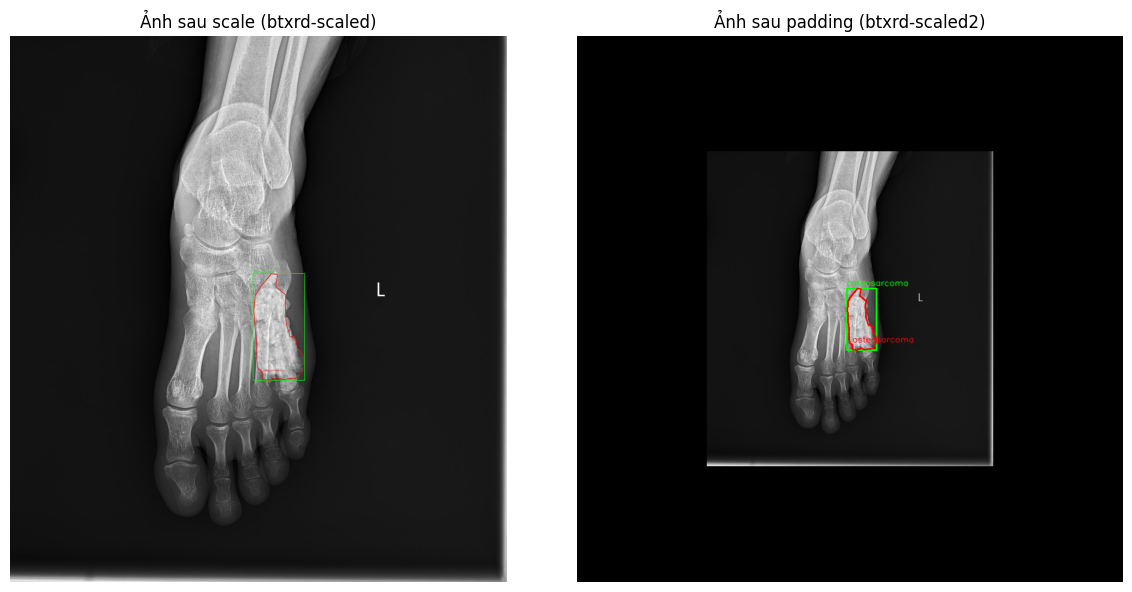

In [4]:
image_dirs = ["/kaggle/input/btxrd-data/BTXRD/BTXRD/images", "/kaggle/working/btxrd-data2/images"]
anno_dirs = ["/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations", "/kaggle/working/btxrd-data2/Annotations"]

# kiểm tra ảnh
image_name = "IMG000004.jpeg"

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Ảnh sau scale (btxrd-scaled)", "Ảnh sau padding (btxrd-scaled2)"]

for i in range(2):
    img_path = os.path.join(image_dirs[i], image_name)
    anno_path = os.path.join(anno_dirs[i], image_name.replace('.jpeg', '.json'))

    # Đọc ảnh
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠ Không tìm thấy ảnh: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển ảnh về RGB

    # Đọc annotation nếu tồn tại
    if os.path.exists(anno_path):
        with open(anno_path, 'r', encoding='utf-8') as f:
            annotation = json.load(f)

        for shape in annotation["shapes"]:
            points = shape["points"]
            label = shape["label"]

            if shape["shape_type"] == "polygon":
                # Vẽ đường bao vùng ung thư (đa giác)
                pts = np.array(points, np.int32)
                pts = pts.reshape((-1, 1, 2))
                cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

                # Vẽ nhãn
                x, y = int(points[0][0]), int(points[0][1])
                cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

            elif shape["shape_type"] == "rectangle":
                # Vẽ hình chữ nhật vùng ung thư
                x1, y1 = map(int, points[0])
                x2, y2 = map(int, points[1])
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Vẽ nhãn
                cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()


# **2) Chia tập dữ liệu**

Dataset btxrd-v3: tách btxrd-v2 thành 3 phần train, test, valid
   + train: 70%
   + valid: 10%
   + test: 20%

In [5]:
# Đường dẫn 
image_dir = "/kaggle/working/btxrd-data2/images"
annotation_dir = "/kaggle/working/btxrd-data2/Annotations"

output_base = "/kaggle/working/BTXRD_v3"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")
valid_dir = os.path.join(output_base, "valid")

In [6]:
# Tạo thư mục lưu ảnh mới
for folder in [train_dir, test_dir, valid_dir]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "Annotations"), exist_ok=True)

# Lấy danh sách ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(image_files)

# Tính số lượng ảnh cho mỗi tập
total = len(image_files)
train_split = int(0.7 * total)
test_split = int(0.2 * total)

# Chia danh sách ảnh
train_files = image_files[:train_split]
test_files = image_files[train_split:train_split + test_split]
valid_files = image_files[train_split + test_split:]

# Hàm di chuyển ảnh và annotation tương ứng
def move_files(files, dest_folder):
    for file in files:
        # Di chuyển ảnh
        shutil.copy(os.path.join(image_dir, file), os.path.join(dest_folder, "images", file))

        # Di chuyển file annotation nếu có
        annotation_file = file.replace(file.split('.')[-1], 'json')  # Đổi đuôi thành .json
        if os.path.exists(os.path.join(annotation_dir, annotation_file)):
            shutil.copy(os.path.join(annotation_dir, annotation_file), os.path.join(dest_folder, "Annotations", annotation_file))

# Di chuyển các tập dữ liệu
move_files(train_files, train_dir)
move_files(test_files, test_dir)
move_files(valid_files, valid_dir)

print(f"Đã chia {total} ảnh thành:")
print(f"- Train: {len(train_files)} ảnh")
print(f"- Test: {len(test_files)} ảnh")
print(f"- Valid: {len(valid_files)} ảnh")


Đã chia 3746 ảnh thành:
- Train: 2622 ảnh
- Test: 749 ảnh
- Valid: 375 ảnh


# **3) Xây dựng mô hình CNN**

In [7]:
n_classes = 2     # normal, tumor
IMG_SIZE = 976

In [8]:
# Đường dẫn dữ liệu
data_dir = '/kaggle/working/BTXRD_v3'
train_images_dir = os.path.join(data_dir, "train", "images")
train_annotations_dir = os.path.join(data_dir, "train", "Annotations")
valid_images_dir = os.path.join(data_dir, "valid", "images")
valid_annotations_dir = os.path.join(data_dir, "valid", "Annotations")
test_images_dir = os.path.join(data_dir, "test", "images")
test_annotations_dir = os.path.join(data_dir, "test", "Annotations")

In [9]:
INPUT_SHAPE = (976, 976, 3)
n_classes = 2

# eccoder
inputs = layers.Input(shape=INPUT_SHAPE)

# Block 1
x = layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip1 = x 

# Block 2
x = layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip2 = x  

# Block 3
x = layers.Conv2D(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip3 = x  

# Block 4
x = layers.Conv2D(256, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
# skip4 = x  

# # Bottleneck
# x = layers.Conv2D(512, (3,3), strides=2, padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)

In [10]:
# Decoder
# # Block 5
# x = layers.Conv2DTranspose(256, (3,3), strides=2, padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Resizing(skip4.shape[1], skip4.shape[2])(x)
# x = layers.Concatenate()([x, skip4])
# x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)

# Block 4
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip3.shape[1], skip3.shape[2])(x)
x = layers.Concatenate()([x, skip3])
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 3
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip2.shape[1], skip2.shape[2])(x)
x = layers.Concatenate()([x, skip2])
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 2
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip1.shape[1], skip1.shape[2])(x)
x = layers.Concatenate()([x, skip1])
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 1 (Khôi phục kích thước gốc)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

outputs = layers.Conv2D(n_classes, (1,1), activation='softmax')(x)


In [11]:
# Compile mô hình
model = models.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Hiển thị cấu trúc mô hình
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 976, 976, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 488, 488, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 488, 488, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 488, 488, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 488, 488, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 244, 244, 64)   │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 244, 244, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 244, 244, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 244, 244, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 122, 122, 128)  │         73,856 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 122, 122, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 122, 122, 128)  │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 122, 122, 128)  │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 61, 61, 256)    │        295,168 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 61, 61, 256)    │          1,024 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 61, 61, 256)    │        590,080 │ batch_normalization_6… │
├──────────────────────

 Total params: 1,961,922 (7.48 MB)

 Trainable params: 1,959,042 (7.47 MB)

 Non-trainable params: 2,880 (11.25 KB)

# **4) Huấn luyện mô hình**

In [12]:
def data_generator(image_dir, annotation_dir, img_size=IMG_SIZE, num_classes=2, batch_size=16):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    while True:  # Generator chạy liên tục
        np.random.shuffle(image_files)  # Xáo trộn ảnh mỗi epoch
        
        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]

            X_batch, y_batch = [], []
            
            for file in batch_files:
                img_path = os.path.join(image_dir, file)
                annotation_path = os.path.join(annotation_dir, file.replace(file.split('.')[-1], 'json'))
                
                # Đọc ảnh
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
                img = img.astype(np.float32) / 255.0  # Giảm bộ nhớ với float32
                
                # Khởi tạo mask mặc định là background (0)
                mask = np.zeros((img_size, img_size), dtype=np.uint8)
                
                if os.path.exists(annotation_path):
                    with open(annotation_path, "r") as f:
                        annotation = json.load(f)

                    for shape in annotation.get("shapes", []):
                        points = np.array(shape["points"], np.int32)
                        if "imageWidth" in annotation:
                            points = (points * img_size / annotation["imageWidth"]).astype(np.int32)
                            cv2.fillPoly(mask, [points], 1)

                # One-hot encoding mask
                mask = to_categorical(mask, num_classes=num_classes).astype(np.float32)

                X_batch.append(img)
                y_batch.append(mask)

            yield np.array(X_batch), np.array(y_batch)  # Trả về batch nhỏ

In [13]:
# Tạo generator
batch_size = 8
train_generator = data_generator(train_images_dir, train_annotations_dir, batch_size=batch_size)
valid_generator = data_generator(valid_images_dir, valid_annotations_dir, batch_size=batch_size)

# Load thử 1 batch để kiểm tra
X_batch, y_batch = next(train_generator)
print(f"Batch Shape: X: {X_batch.shape}, y: {y_batch.shape}")

Batch Shape: X: (8, 976, 976, 3), y: (8, 976, 976, 2)


In [14]:
# Compile mô hình
# Hàm IoU (Intersection over Union)
def iou_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

model.compile(optimizer=Adam(learning_rate=1e-4),  # Learning rate nhỏ để ổn định training
              loss=CategoricalCrossentropy(),  # Hàm mất mát phù hợp với phân loại đa lớp
              metrics=["accuracy", iou_metric])  # Thêm IoU để theo dõi

In [15]:
# Callback giảm learning rate nếu val_loss không cải thiện
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Callback lưu mô hình tốt nhất trong quá trình train
checkpoint = ModelCheckpoint("unet_v1.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Số batch mỗi epoch (số ảnh chia cho batch_size)
steps_per_epoch = len(os.listdir(train_images_dir)) // batch_size
validation_steps = len(os.listdir(valid_images_dir)) // batch_size

starting_time = time.time()

# Huấn luyện mô hình với generator
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50, 
    steps_per_epoch=steps_per_epoch,  
    validation_steps=validation_steps,  
    callbacks=[checkpoint, reduce_lr]
)
print('> Training time is %.4f minutes' % ((time.time() - starting_time) / 60))

Epoch 1/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.7666 - iou_metric: 0.6485 - loss: 0.6835
Epoch 1: val_loss improved from inf to 0.50129, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 228s 582ms/step - accuracy: 0.7669 - iou_metric: 0.6491 - loss: 0.6834 - val_accuracy: 0.9987 - val_iou_metric: 0.9975 - val_loss: 0.5013 - learning_rate: 1.0000e-04
Epoch 2/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9959 - iou_metric: 0.9918 - loss: 0.4903
Epoch 2: val_loss improved from 0.50129 to 0.35067, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 164s 500ms/step - accuracy: 0.9959 - iou_metric: 0.9918 - loss: 0.4901 - val_accuracy: 0.9988 - val_iou_metric: 0.9975 - val_loss: 0.3507 - learning_rate: 1.0000e-04
Epoch 3/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9984 - iou_metric: 0.9968 - loss: 0.3077
Epoch 3: val_loss improved from 0.35067 to 0.20613, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 156s 478ms/s

# **5) Đánh giá mô hình**

Dựa trên MeanIoU, Dice Coefficent và kiểm tra trên tập test

In [76]:
# Load tập dữ liệu test
test_generator = data_generator(test_images_dir, test_annotations_dir, batch_size=1)

# Lấy một batch test
X_test, y_test = next(test_generator)

# Dự đoán bằng mô hình
y_pred = model.predict(X_test)

# Chuyển về dạng nhãn (bỏ one-hot encoding)
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(y_pred, axis=-1)

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)  # Vùng giao
    union = np.logical_or(y_true, y_pred)  # Vùng hợp
    return np.sum(intersection) / (np.sum(union) + 1e-6)  # Tránh chia cho 0

def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + epsilon)  # Tránh chia cho 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [84]:
# Khởi tạo lại test_generator để tránh lỗi StopIteration
test_generator = data_generator(test_images_dir, test_annotations_dir, batch_size=1)

iou_scores = []
dice_scores = []
total_images = 0

# Lấy tổng số ảnh trong thư mục test
total_images_in_test = len(os.listdir(test_images_dir))

for X_test, y_test in test_generator:
    y_pred = model.predict(X_test, verbose=0)

    y_true = np.argmax(y_test, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    iou = iou_score(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)

    iou_scores.append(iou)
    dice_scores.append(dice)

    total_images += 1
    if total_images >= total_images_in_test:  # Dừng khi đã xử lý đủ ảnh
        break

# Tính giá trị trung bình trên toàn bộ tập test
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)

print(f"Predicted Tumor Images: {num_tumor_pred}")
print(f"Predicted Normal Images: {num_normal_pred}")
print(f"Mean IoU on test set: {mean_iou:.4f}")
print(f"Mean Dice Score on test set: {mean_dice:.4f}")


Predicted Tumor Images: 502
Predicted Normal Images: 247
Mean IoU on test set: 0.0192
Mean Dice Score on test set: 0.0310


In [81]:
num_tumor_pred_pixels = np.sum(y_pred == 1)
print(f"Total predicted tumor pixels: {num_tumor_pred_pixels}")


Total predicted tumor pixels: 176


In [83]:
num_tumor_pixels = np.sum(y_true == 1)
print(f"Total tumor pixels in ground truth: {num_tumor_pixels}")


Total tumor pixels in ground truth: 739


In [67]:
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_true: [0]
Unique values in y_pred: [0 1]


khúc này trở xuống chưa chạy đc

In [ ]:
# kiểm tra một ảnh đơn lẻ
# này đang lỗi (chưa nhận diện được khối u)

def predict_single_image(image_path, model):
    # Đọc và xử lý ảnh giống như trong load_data
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w))
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều kênh
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension (1, img_h, img_w, 1)
    
    # Dự đoán
    prediction = model.predict(img)
    
    # Kết quả
    class_idx = np.argmax(prediction)  # Chọn lớp có xác suất cao nhất
    if class_idx == 1:
        print("Ảnh này có khả năng chứa khối u / ung thư.")
    else:
        print("Ảnh này không có khối u / ung thư.")
    
    return prediction

# Chạy thử một ảnh
test_image_path = '/kaggle/input/btxrd-v2/test/images/IMG000005.jpeg'
predict_single_image(test_image_path, model)
